In [64]:
import IPython.display as ipd
import json
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Dict, List, Optional
from pathlib import Path

def plot_sample_from_manifest(data: Dict, max_duration: Optional[float] = None, save_path: str = "", repeat: int = 1, unit_frame = 0.01):
    audio_file = data['audio_filepath']
    labels = [float(x) for x in data['label'].split()]
    
    if repeat > 1:
        labels = np.repeat(labels, repeat)
    
    duration = data['duration']
    offset = data.get('offset', 0.0)

    if max_duration:
        duration = min(duration, max_duration)

    plt.figure(figsize=[20, 2])
    UNIT_FRAME_LEN = unit_frame

    audio, sample_rate = librosa.load(path=audio_file, sr=16000, mono=True, offset=offset, duration=duration)
    dur = librosa.get_duration(y=audio, sr=sample_rate)

    time = np.arange(offset, offset + dur, UNIT_FRAME_LEN)

    length = len(labels)
    ax1 = plt.subplot()
    ax1.set_title(audio_file)
    ax1.plot(np.arange(audio.size) / sample_rate, audio, 'gray')
    ax1.set_xlim([0, int(dur) + 1])
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_ylabel('Signal')
    ax1.set_ylim([-1, 1])
    ax2 = ax1.twinx()

    ax2.plot(np.arange(length) * UNIT_FRAME_LEN, labels, 'r', label='label')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc='lower right', shadow=True)
    ax2.set_ylabel('Labels')
    ax2.set_ylim([-0.1, 1.1])
    plt.show()
    if save_path != "":
        plt.savefig(save_path)
    return ipd.Audio(audio, rate=16000)

def load_manifest_data(manifest_file):
    results = []
    with Path(manifest_file).open("r") as fin:
        for line in fin.readlines():
            item = json.loads(line.strip())
            results.append(item)
    return results

In [36]:
manifest_dir = Path("/media/data/projects/NeMo-fvad/vad_code/manifests_sd_eval_40ms")
mode = "dev"
split = "socio_lab"
manifest_file = manifest_dir / f"dh3_{mode}_{split}_manifest.json"
manifest_data = load_manifest_data(manifest_file)
print(len(manifest_data))

16


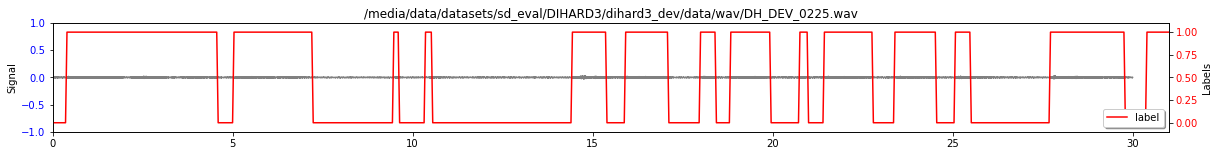

In [37]:
idx = np.random.permutation(len(manifest_data))[0]
key = "DH_DEV_0225"
for i,item in enumerate(manifest_data):
    if key in item["audio_filepath"]:
        idx = i
plot_sample_from_manifest(manifest_data[idx], max_duration = 30, unit_frame = 0.04)


In [65]:
import json
from pathlib import Path
import numpy as np

from plot_utils import plot_sample, plot_sample_from_rttm

def load_manifest(manifest_file):
    results = {}
    with Path(manifest_file).open("r") as fin:
        for line in fin.readlines():
            item = json.loads(line.strip())
            audio_file = item["audio_filepath"]
            key = Path(audio_file).stem
            results[key] = audio_file
    return results

def load_frames(data_dir):
    results = {}
    for frames_file in Path(data_dir).glob("*.frame"):
        key = frames_file.stem
        results[key] = str(frames_file)
    return results


In [70]:
exp_dir = "drc_marblenet_3x2x64_SynthMulti_sgdlr1e-2minlr1e-4_wd1e-3_aug10x0.05_b64_gacc1_ep50_multisynth_s2_wce_ep50_n4"
# exp_dir = "drc_marblenet_3x2x64_Mixed_sgdlr1e-2minlr1e-4_wd1e-3_aug10x0.05_b64_gacc1_ep50_synth1k_s2_wce_ep50_n4"
root_dir = Path("/media/data/projects/NeMo-fvad/vad_code/nemo_experiments/Frame_VAD") / exp_dir / "frame_vad_multi_output_sd_dev"
situation = "socio_lab"  #  socio_lab, socio_field, meeting, clinical, restaurant
test_folder = root_dir / Path(f"vad_output_dh3_dev_{situation}_manifest")

manifest_file = test_folder / Path("manifest_vad_input.json")
pred_frame_dir = test_folder / Path("frames_predictions")
gt_frame_dir = test_folder / Path("frames_groundtruth")

audio_dict = load_manifest(manifest_file)
pred_frame_dict = load_frames(pred_frame_dir)
gt_frame_dict = load_frames(gt_frame_dir)
print(len(audio_dict), len(pred_frame_dict), len(gt_frame_dict))

16 16 16


In [71]:
post_args = {
    "onset": 0.5, # onset threshold for detecting the beginning and end of a speech
    "offset": 0.5, # offset threshold for detecting the end of a speech.
    "pad_onset": 0.1, # adding durations before each speech segment
    "pad_offset": 0.0, # adding durations after each speech segment
    "min_duration_on": 0.0, # threshold for small non_speech deletion
    "min_duration_off": 0.1, # threshold for short speech segment deletion
    "filter_speech_first": True, 
    "frame_length_in_sec": 0.02, 
}
duration = None


In [50]:
# num_samples = 1
# label_repeat = 2
# unit_frame_len = 0.02
# duration = 30
# all_keys = sorted(list(audio_dict.keys()))
# keys_sampled = np.random.choice(all_keys, num_samples) #  all_keys[:num_samples] #np.random.choice(all_keys, num_samples)
# for key in keys_sampled:
#     plot_sample(audio_dict[key], pred_frame_dict[key], gt_frame_dict[key], per_args=post_args, duration=duration, unit_frame_len=unit_frame_len, label_repeat=label_repeat)
    

DH_DEV_0078


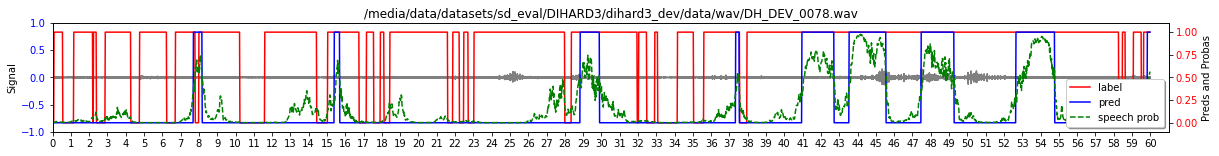

In [72]:
unit_frame_len = 0.02
all_keys = sorted(list(audio_dict.keys()))
duration = 60
key = "DH_DEV_0078"#str(np.random.choice(all_keys, 1)[0])
# key = str(np.random.choice(all_keys, 1)[0])
print(key)
plot_sample(audio_dict[key], pred_frame_dict[key], gt_frame_dict[key], per_args=post_args, duration=duration, unit_frame_len=unit_frame_len)


In [73]:
# exp_dir = "drc_marblenet_3x2x64_SynthMulti_sgdlr1e-2minlr1e-4_wd1e-3_aug10x0.05_b64_gacc1_ep50_multisynth_s2_wce_ep50_n4"
exp_dir2 = "drc_marblenet_3x2x64_Mixed_sgdlr1e-2minlr1e-4_wd1e-3_aug10x0.05_b64_gacc1_ep50_synth1k_s2_wce_ep50_n4"
root_dir2 = Path("/media/data/projects/NeMo-fvad/vad_code/nemo_experiments/Frame_VAD") / exp_dir2 / "frame_vad_multi_output_sd_dev"
# situation = "clinical"
test_folder2 = root_dir2 / Path(f"vad_output_dh3_dev_{situation}_manifest")

manifest_file2 = test_folder2 / Path("manifest_vad_input.json")
pred_frame_dir2 = test_folder2 / Path("frames_predictions")
gt_frame_dir2 = test_folder2 / Path("frames_groundtruth")

audio_dict2 = load_manifest(manifest_file2)
pred_frame_dict2 = load_frames(pred_frame_dir2)
gt_frame_dict2 = load_frames(gt_frame_dir2)
print(len(audio_dict2), len(pred_frame_dict2), len(gt_frame_dict2))

16 16 16


DH_DEV_0078


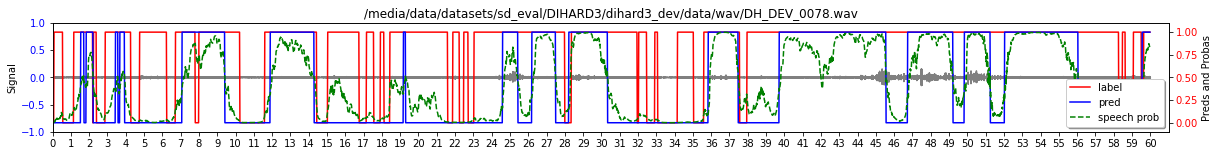

In [74]:
unit_frame_len = 0.02
all_keys2 = sorted(list(audio_dict2.keys()))
# key = "DH_DEV_0185" # str(np.random.choice(all_keys, 1)[0])
print(key)
plot_sample(audio_dict2[key], pred_frame_dict2[key], gt_frame_dict2[key], per_args=post_args, duration=duration, unit_frame_len=unit_frame_len)


### Overall

- hard to detect voice far from microphone
- hard to detect low-volume words

### clinical: 

- DH_DEV_0185: kid murmur
- DH_DEV_0243: low-volumn "yean",
- DH_DEV_0224: low-volumn "well",
- DH_DEV_0107: 
    - "em humm", hard to identify "well", 
    - 26-27s false label due to silenced privacy info
- DH_DEV_0099:
    - 3-4s "beeeeeeeeenmm"
    - 9s "eeeeh",
    - 13-16 "hmmmmmmmmmmmmmm"
- DH_DEV_0200:
    - fail on low-volumn words
- DH_DEV_0148:
    - 6-8s false label due to silenced privacy info
    - 17-20 "waaaaaaaaaaaaaaaa"
    


### Meeting

- DH_DEV_0163: 0-4s false negative labels
- DH_DEV_0040: 
    - fail on "and", "uhm"
    - fail on low-volume 19-21s
- DH_DEV_0217: fail on a lot of low-vol mixed voices


### Restaurant
- DH_DEV_0154:
    - 0-1.5s noise louder than voice
    - 8-9s "yeyeyeyeah"
- DH_DEV_0146:
    - a lot of low-vol voices
- DH_DEV_0062:
    - 23-28s hard to distinguish voice
   
### Socio-Lab
- DH_DEV_0071: short phrases like "good"
- DH_DEV_0078: 
    - nor sure why it's difficult, volume variety is large
- DH_DEV_0221: fails a lot on low-vol voice


In [66]:
exp_dir3 = "drc_marblenet_3x2x64_Mixed_sgdlr1e-2minlr1e-4_wd1e-3_aug10x0.05_b64_gacc1_ep50_synth1k_s2_wce_ep50_n4"
root_dir3 = Path("/media/data/projects/NeMo-fvad/vad_code/nemo_experiments/Frame_VAD") / exp_dir3 / "frame_vad_multi_output_sd_dev"
test_folder3 = root_dir3 / Path(f"vad_output_voxconv_test_full_manifest")

manifest_file3 = test_folder3/ Path("manifest_vad_input.json")
pred_frame_dir3 = test_folder3 / Path("frames_predictions")
gt_frame_dir3 = test_folder3 / Path("frames_groundtruth")

audio_dict3 = load_manifest(manifest_file3)
pred_frame_dict3 = load_frames(pred_frame_dir3)
gt_frame_dict3 = load_frames(gt_frame_dir3)
print(len(audio_dict3), len(pred_frame_dict3), len(gt_frame_dict3))

232 232 232


zzsba


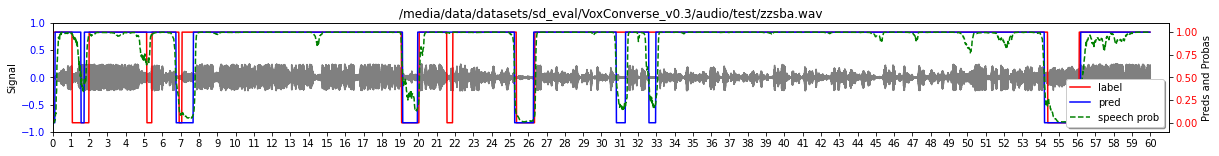

In [69]:
unit_frame_len = 0.02
duration = 60
all_keys3 = sorted(list(audio_dict3.keys()))
key = str(np.random.choice(all_keys3, 1)[0])
print(key)
plot_sample(audio_dict3[key], pred_frame_dict3[key], gt_frame_dict3[key], per_args=post_args, duration=duration, unit_frame_len=unit_frame_len)
